# "Cross-validation" des modèles

In [1]:
learning_rate = 0.04
num_epochs = 200
N = 150
N_cv = 10
seed = 42
batch_size = N//2
batch_size = N//4

N_test = 0
N_test = 1000
N_scan = 9

In [2]:
import numpy as np
import matplotlib.pyplot as plt

## Creer des données synthetiques 

In [3]:
def get_data(
            N = N,
            p0 = 0.05,
            theta0 = 0,
            wt = np.pi/8,
            theta_std = np.pi/6,
            seed=seed):
    np.random.seed(42)
    theta = np.random.randn(N)*theta_std
    a = (theta-theta0)/wt
    p = 1/(1+np.exp(-a))
    
    p = p0/2 + (1-p0) * p
    y = np.random.rand(N) < p
    return theta, p, y

In [4]:
import torch
from torch.utils.data import TensorDataset, DataLoader

torch.set_default_tensor_type('torch.DoubleTensor')
criterion = torch.nn.BCELoss()
class LogisticRegressionModel(torch.nn.Module):
    def __init__(self, bias=True):
        super(LogisticRegressionModel, self).__init__()
        self.linear = torch.nn.Linear(1, 1, bias=bias)    
        self.logit0 = torch.nn.Linear(1, 1) 

    def forward(self, x):
        p0 = torch.sigmoid(self.logit0(torch.zeros(1)))
        out = p0/2 + (1-p0)*torch.sigmoid(self.linear(x))
        return out

def fit_data(theta, y, 
                learning_rate =learning_rate,
                num_epochs = num_epochs,
                batch_size = batch_size,
                verbose=False):

    logistic_model = LogisticRegressionModel()

    labels = torch.Tensor(y[:, None])
    Theta = torch.Tensor(theta[:, None])

    loader = DataLoader(TensorDataset(Theta, labels), batch_size=batch_size, shuffle=True)
    optimizer = torch.optim.Adam(logistic_model.parameters(), lr=learning_rate/len(loader))
    
    for epoch in range(int(num_epochs)):
        losses = []
        for Theta_, labels_ in loader:
            optimizer.zero_grad()
            outputs = logistic_model(Theta_)
            loss = criterion(outputs, labels_)
            loss.backward()
            optimizer.step()
            losses.append(loss.item())
        
        if verbose and (epoch % (num_epochs//32) == 0) : 
            print(f"Iteration: {epoch} - Loss: {np.mean(losses):.5f}")

    logistic_model.eval()
    return logistic_model, np.mean(losses)

In [5]:
%%timeit
theta, p, y = get_data()

22.1 µs ± 1.5 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [6]:
theta, p, y = get_data()
logistic_model, loss = fit_data(theta, y, verbose=True)

Iteration: 0 - Loss: 0.74515
Iteration: 6 - Loss: 0.70979
Iteration: 12 - Loss: 0.68670
Iteration: 18 - Loss: 0.67567
Iteration: 24 - Loss: 0.65834
Iteration: 30 - Loss: 0.62680
Iteration: 36 - Loss: 0.61823
Iteration: 42 - Loss: 0.63673
Iteration: 48 - Loss: 0.56117
Iteration: 54 - Loss: 0.54958
Iteration: 60 - Loss: 0.55800
Iteration: 66 - Loss: 0.53983
Iteration: 72 - Loss: 0.49918
Iteration: 78 - Loss: 0.50808
Iteration: 84 - Loss: 0.51221
Iteration: 90 - Loss: 0.58434
Iteration: 96 - Loss: 0.51632
Iteration: 102 - Loss: 0.46920
Iteration: 108 - Loss: 0.56009
Iteration: 114 - Loss: 0.52861
Iteration: 120 - Loss: 0.49438
Iteration: 126 - Loss: 0.49009
Iteration: 132 - Loss: 0.56850
Iteration: 138 - Loss: 0.58544
Iteration: 144 - Loss: 0.65259
Iteration: 150 - Loss: 0.54740
Iteration: 156 - Loss: 0.52523
Iteration: 162 - Loss: 0.60853
Iteration: 168 - Loss: 0.46648
Iteration: 174 - Loss: 0.51042
Iteration: 180 - Loss: 0.44726
Iteration: 186 - Loss: 0.49754
Iteration: 192 - Loss: 0.58

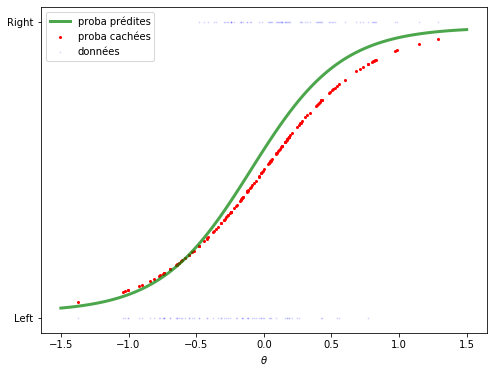

In [7]:
plt.figure(figsize = (8,6)) 
plt.scatter(theta, p, s=4, color = 'r', label='proba cachées')
plt.scatter(theta, y, s=1, alpha=.1, color = 'b', label='données')
x_values = np.linspace(-1.5, 1.50, 100)[:, None]
y_values = logistic_model(torch.Tensor(x_values)).detach().numpy()
plt.plot(x_values, y_values, 'g', alpha=.7, lw=3, label='proba prédites')
plt.xlabel(r'$\theta$')
plt.yticks([0.,1.],['Left', 'Right']);
plt.legend();


In [8]:
%%timeit
logistic_model, loss = fit_data(theta, y, verbose=False)

783 ms ± 70.8 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


## validation

loss= tensor(0.5323, grad_fn=<BinaryCrossEntropyBackward>)


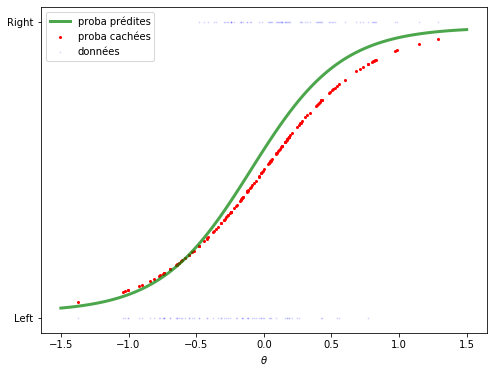

In [9]:
theta, p, y = get_data() # nouvelles données 

labels = torch.Tensor(y[:, None])
Theta = torch.Tensor(theta[:, None])
outputs = logistic_model(Theta)
loss = criterion(outputs, labels)
print('loss=', loss)
plt.figure(figsize = (8,6)) 
plt.scatter(theta, p, s=4, color = 'r', label='proba cachées')
plt.scatter(theta, y, s=1, alpha=.1, color = 'b', label='données')
x_values = np.linspace(-1.5, 1.50, 100)[:, None]
y_values = logistic_model(torch.Tensor(x_values)).detach().numpy()
plt.plot(x_values, y_values, 'g', alpha=.7, lw=3, label='proba prédites')
plt.xlabel(r'$\theta$')
plt.yticks([0.,1.],['Left', 'Right']);
plt.legend();

## influence du nombre de trials

In [10]:
Ns = np.logspace(1, 3, N_scan, base=10)
Ns_, losses, KLs = [], [], []
p0s, theta0s, wts = [], [], []
for N_ in Ns:
    for i_CV in range(N_cv):
        theta, p, y = get_data(N=int(N_), seed=seed+i_CV)
        logistic_model, loss = fit_data(theta, y, verbose=False)
        
        if N_test>0: theta, p, y = get_data(N=N_test) # nouvelles données 
        labels = torch.Tensor(y[:, None])
        Theta = torch.Tensor(theta[:, None])
        outputs = logistic_model(Theta)
        loss = criterion(outputs, labels).item()
        KL = criterion(outputs, torch.Tensor(p[:, None])).item()
        if i_CV==0: print(f"N: {int(N_)}, Loss: {loss:.5f}, KL: {KL:.5f}")
        Ns_.append(N_)
        KLs.append(KL)
        losses.append(loss)

N: 10, Loss: 0.87370, KL: 0.84585
N: 17, Loss: 0.66925, KL: 0.65266
N: 31, Loss: 0.58960, KL: 0.58871
N: 56, Loss: 0.57962, KL: 0.57419
N: 100, Loss: 0.57558, KL: 0.57225
N: 177, Loss: 0.57400, KL: 0.57142
N: 316, Loss: 0.58399, KL: 0.57815
N: 562, Loss: 0.57474, KL: 0.57119
N: 1000, Loss: 0.57361, KL: 0.57132


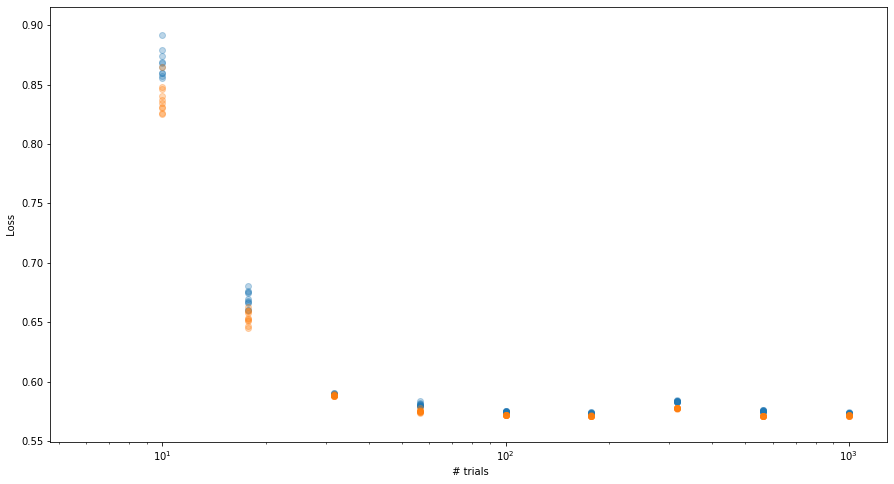

In [11]:
fig, ax = plt.subplots(figsize = (15, 8)) 
ax.scatter(Ns_, losses, alpha=3/N_cv, label='loss')
ax.scatter(Ns_, KLs, alpha=3/N_cv, label='KL')

ax.set_xlabel(' # trials')
ax.set_ylabel(' Loss ')
ax.set_xscale('log')

## influence du nombre du learning rate

In [12]:
learning_rates = learning_rate * np.logspace(-1, 1, N_scan, base=10)
learning_rates_, losses, KLs = [], [], []
for learning_rate_ in learning_rates:
    for i_CV in range(N_cv):
        theta, p, y = get_data(seed=seed+i_CV)
        logistic_model, loss = fit_data(theta, y, learning_rate=learning_rate_, verbose=False)

        if N_test>0: theta, p, y = get_data(N=N_test) # nouvelles données 
        labels = torch.Tensor(y[:, None])
        Theta = torch.Tensor(theta[:, None])
        outputs = logistic_model(Theta)

        loss = criterion(outputs, labels).item()
        KL = criterion(outputs, torch.Tensor(p[:, None])).item()
        if i_CV==0: 
            print(f"learning_rate: {learning_rate_:.5f}, Loss: {loss:.5f}, KL: {KL:.5f}")
        learning_rates_.append(learning_rate_)
        KLs.append(KL)
        losses.append(loss)

learning_rate: 0.00400, Loss: 0.63557, KL: 0.63378
learning_rate: 0.00711, Loss: 0.60707, KL: 0.60540
learning_rate: 0.01265, Loss: 0.59179, KL: 0.58896
learning_rate: 0.02249, Loss: 0.57752, KL: 0.57291
learning_rate: 0.04000, Loss: 0.58561, KL: 0.57882
learning_rate: 0.07113, Loss: 0.58446, KL: 0.57775
learning_rate: 0.12649, Loss: 0.58022, KL: 0.57592
learning_rate: 0.22494, Loss: 0.57964, KL: 0.57650
learning_rate: 0.40000, Loss: 0.59070, KL: 0.58410


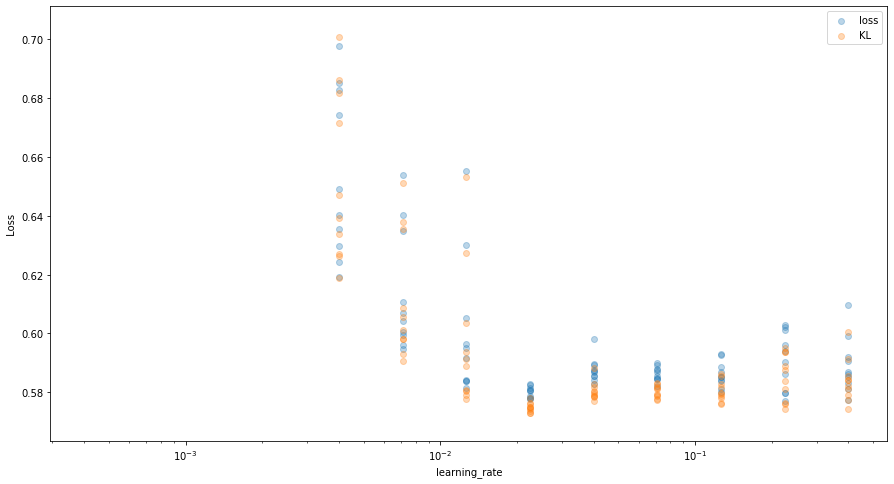

In [13]:
fig, ax = plt.subplots(figsize = (15, 8)) 
ax.scatter(learning_rates_, losses, alpha=3/N_cv, label='loss')
ax.scatter(learning_rates_, KLs, alpha=3/N_cv, label='KL')

ax.set_xlabel('learning_rate')
ax.set_xlim(learning_rates_.min(), learning_rates_.max())
ax.set_ylabel(' Loss ')
ax.set_xscale('log')
ax.legend(loc='best');

## influence du nombre d'epochs

In [14]:
num_epochss = num_epochs * np.logspace(-1, 1, N_scan, base=10)
num_epochss_, losses, KLs = [], [], []
for num_epochs_ in num_epochss:
    for i_CV in range(N_cv):
        theta, p, y = get_data(seed=seed+i_CV)
        logistic_model, loss = fit_data(theta, y, num_epochs=int(num_epochs_), verbose=False)
        
        if N_test>0: theta, p, y = get_data(N=N_test) # nouvelles données 
        labels = torch.Tensor(y[:, None])
        Theta = torch.Tensor(theta[:, None])
        outputs = logistic_model(Theta)

        loss = criterion(outputs, labels).item()
        KL = criterion(outputs, torch.Tensor(p[:, None])).item()
        if i_CV==0: 
            print(f"num_epochs: {int(num_epochs_)}, Loss: {loss:.5f}, KL: {KL:.5f}")
        num_epochss_.append(num_epochs_)
        KLs.append(KL)
        losses.append(loss)

num_epochs: 20, Loss: 0.68789, KL: 0.68800
num_epochs: 35, Loss: 0.60854, KL: 0.60434
num_epochs: 63, Loss: 0.58839, KL: 0.58433
num_epochs: 112, Loss: 0.58197, KL: 0.57577
num_epochs: 200, Loss: 0.58534, KL: 0.57832
num_epochs: 355, Loss: 0.58351, KL: 0.57774
num_epochs: 632, Loss: 0.58380, KL: 0.57863
num_epochs: 1124, Loss: 0.58576, KL: 0.58019
num_epochs: 2000, Loss: 0.58470, KL: 0.58001


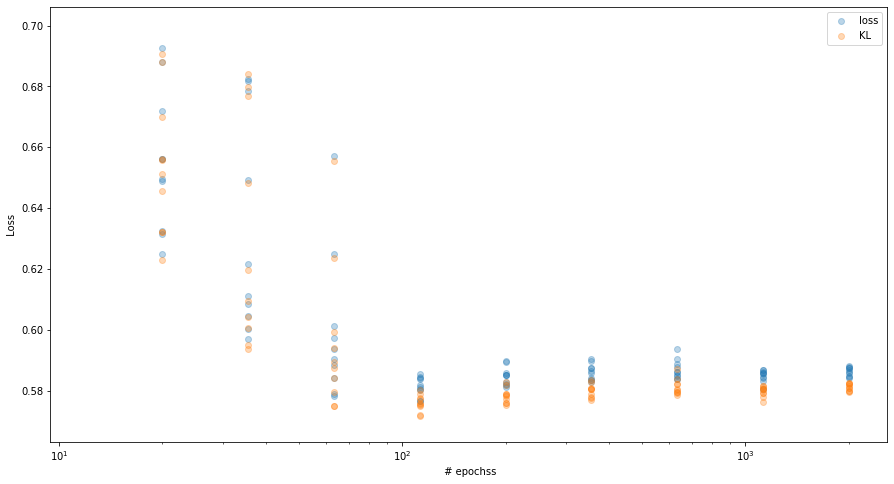

In [15]:
fig, ax = plt.subplots(figsize = (15, 8)) 
ax.scatter(num_epochss_, losses, alpha=3/N_cv, label='loss')
ax.scatter(num_epochss_, KLs, alpha=3/N_cv, label='KL')

ax.set_xlabel(' # epochss')
ax.set_ylabel(' Loss ')
ax.set_xscale('log')
ax.legend(loc='best');

## influence de la taille du minibatch

In [ ]:
batch_sizes = N * np.logspace(-3, 0, N_scan, base=2)
batch_sizes_, losses, KLs = [], [], []
for batch_size_ in batch_sizes:
    for i_CV in range(N_cv):
        theta, p, y = get_data(seed=seed+i_CV)
        logistic_model, loss = fit_data(theta, y, batch_size=int(batch_size_), verbose=False)
        
        if N_test>0: theta, p, y = get_data(N=N_test) # nouvelles données 
        labels = torch.Tensor(y[:, None])
        Theta = torch.Tensor(theta[:, None])
        outputs = logistic_model(Theta)

        loss = criterion(outputs, labels).item()
        KL = criterion(outputs, torch.Tensor(p[:, None])).item()
        if i_CV==0: 
            print(f"batch_size: {int(batch_size_)}, Loss: {loss:.5f}, KL: {KL:.5f}")
        batch_sizes_.append(batch_size_)
        KLs.append(KL)
        losses.append(loss)

batch_size: 18, Loss: 0.58365, KL: 0.57796


In [ ]:
fig, ax = plt.subplots(figsize = (15, 8)) 
ax.scatter(batch_sizes_, losses, alpha=3/N_cv, label='loss')
ax.scatter(batch_sizes_, KLs, alpha=3/N_cv, label='KL')

ax.set_xlabel(' batch_size')
ax.set_ylabel(' Loss ')
ax.set_xscale('log')
ax.legend(loc='best');